This is a simulation of the rerouting algorithm. We will be using the PUJ route T307 (Boni - Pinatubo → Stop n' Shop).

In [32]:
!pip3 install -q osmnx contextily overpass overpy osmapi

In [22]:
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd

## Prepare Data

### Creating Bounding Box

In [23]:
BOUNDING_BOX = (14.60692, 14.56838, 121.06303, 120.99891) # bounding box as (north, south, east, west)
graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)

/tmp/ipykernel_236/3675650549.py:2: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph_of_area = ox.graph_from_bbox(bbox=BOUNDING_BOX)


### Plot Area

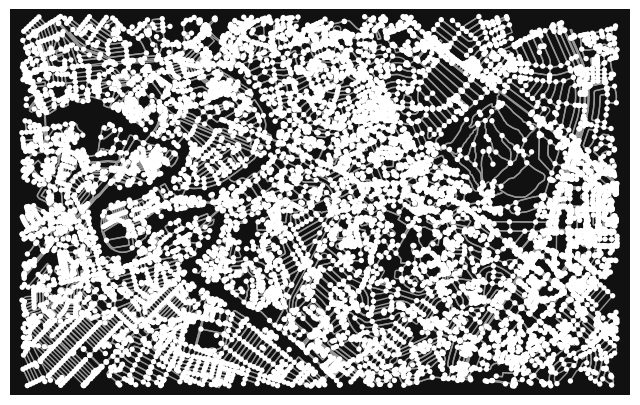

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [24]:
ox.plot_graph(graph_of_area)

In [25]:
gdf_edges = ox.graph_to_gdfs(graph_of_area, nodes=False)

In [26]:
gdf_edges.head()

osmid  oneway lanes  ref  \
u        v          key                                                        
12067613 1981388318 0                           264965502    True     4    1   
         962953430  0    [29256184, 188165094, 188165111]    True     2    1   
12067619 6970838871 0                          1254512972    True   NaN  NaN   
         8459730704 0                           671955931    True     2    1   
12067627 8242414108 0                            22598208   False     2  NaN   

                                          name   highway maxspeed reversed  \
u        v          key                                                      
12067613 1981388318 0                     EDSA     trunk       60    False   
         962953430  0                     EDSA     trunk       60    False   
12067619 6970838871 0    Starmall Service Road   service      NaN    False   
         8459730704 0                     EDSA     trunk       60    False   
12067627 8242414108 0               Apo Street  tertiary      NaN    False   

                          length tunnel  \
u        v          key                   
12067613 1981388318 0     15.937    NaN   
         962953430  0    860.735    yes   
12067619 6970838871 0      5.014    NaN   
         8459730704 0    199.554    NaN   
12067627 8242414108 0      6.785    NaN   

                                                                  geometry  \
u        v          key                                                      
12067613 1981388318 0    LINESTRING (121.05548 14.58452, 121.05537 14.5...   
         962953430  0    LINESTRING (121.05548 14.58452, 121.05543 14.5...   
12067619 6970838871 0    LINESTRING (121.05468 14.58309, 121.05464 14.5...   
         8459730704 0    LINESTRING (121.05468 14.58309, 121.05400 14.5...   
12067627 8242414108 0    LINESTRING (121.04673 14.57158, 121.04667 14.5...   

                             access service width junction bridge  
u        v          key                                            
12067613 1981388318 0           NaN     NaN   NaN      NaN    NaN  
         962953430  0           NaN     NaN   NaN      NaN    NaN  
12067619 6970838871 0    permissive     NaN   NaN      NaN    NaN  
         8459730704 0           NaN     NaN   NaN      NaN    NaN  
12067627 8242414108 0           NaN     NaN   NaN      NaN    NaN

In [27]:
gdf_edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
gdf_edges_web_mercator = gdf_edges.to_crs(epsg=3857)

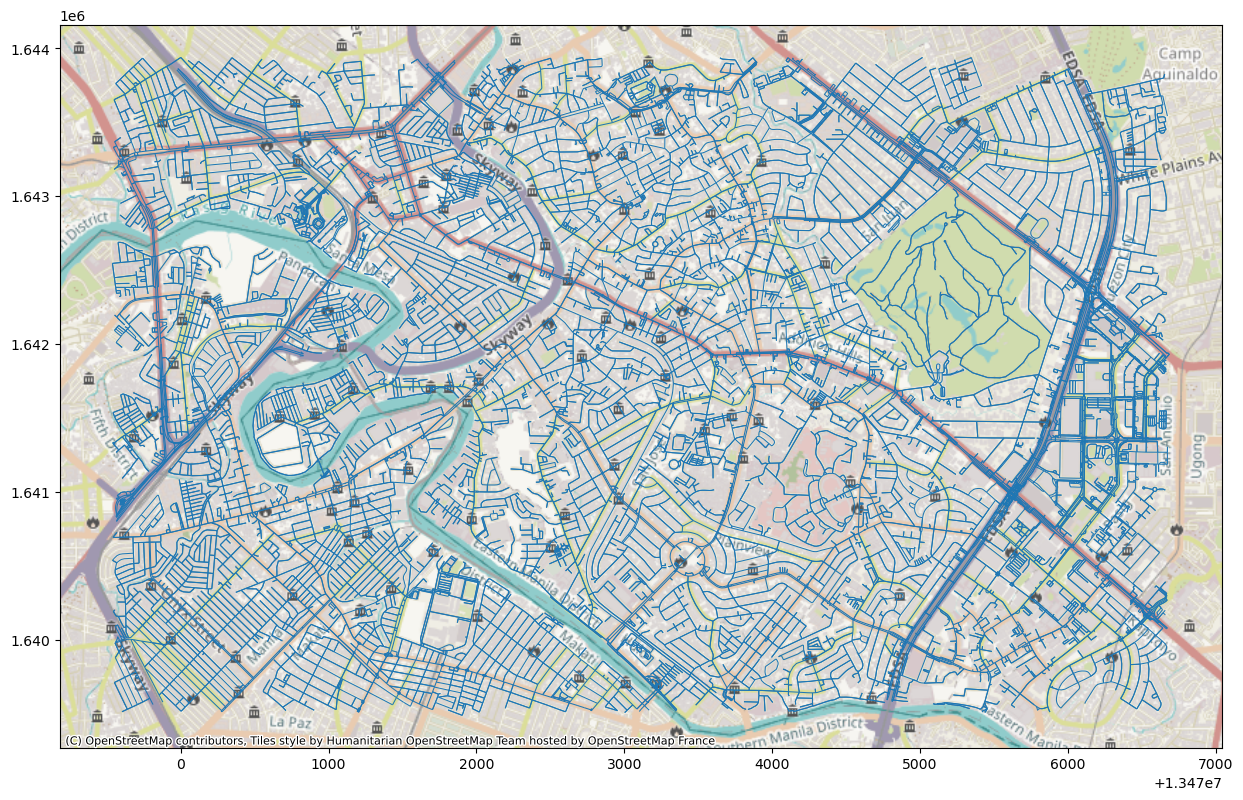

In [29]:
_, ax = plt.subplots(1,1, figsize=(15,15))
gdf_edges_web_mercator.plot(linewidth=.75, ax=ax)
cx.add_basemap(ax=ax, url=cx.providers.CartoDB.Positron)

In [33]:
import overpass
import json
import osmnx as ox
import geopandas as gpd

from shapely.geometry import Polygon, LineString, Point
import overpy
from osmapi import OsmApi

### Using overpy

In [44]:
# Initialize Overpass API
api = overpy.Overpass()

# Specify the relation ID you want to query
relation_id = 11246072  # Replace with the actual relation ID

In [45]:
# Query to fetch the relation by ID
query = f"""
relation({relation_id});
out body;
"""

# Fetch the relation data
result = api.query(query)

# Check if we got the relation
if len(result.relations) > 0:
    relation = result.relations[0]  # Access the first relation
else:
    print("No relation found.")

In [46]:
node_ids = []
way_ids = []
for member in relation.members:
    if type(member) == overpy.RelationNode:
        node_ids.append(member.ref)
    elif type(member) == overpy.RelationWay:
        way_ids.append(member.ref)

In [47]:
query = f"""
node(id:{','.join(map(str, node_ids))});
out body;
"""
result = api.query(query)
    
def get_nodes():
    for node in result.get_nodes():
        yield Point(node.lon, node.lat)

In [66]:
query = f"""
way(id:{','.join(map(str, way_ids))});
out body;
"""
result = api.query(query)

def get_ways():

    for way in result.get_ways():
        yield LineString(Point(node.lon, node.lat) for node in way.get_nodes(resolve_missing=True)) 

In [73]:
# initialize node ids
for way in result.get_ways():
    way.get_nodes(resolve_missing=True)

### Create Subgraph

In [74]:
subgraph = graph_of_area.subgraph(result.get_node_ids())

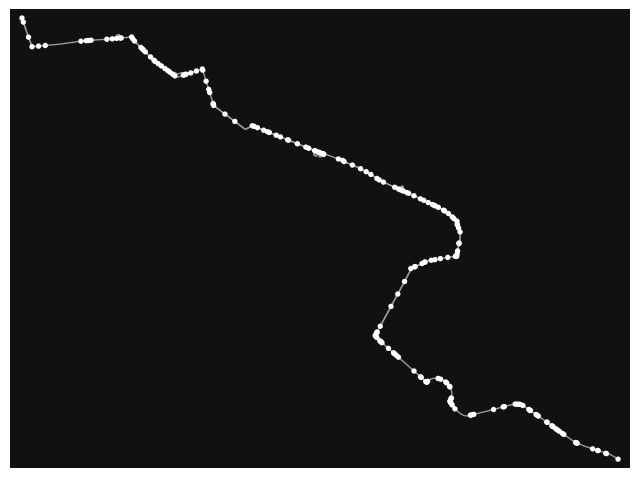

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [75]:
ox.plot_graph(subgraph)

In [36]:
import networkx as nx

In [38]:
# Copy relevant edge attributes from the main graph to the subgraph
# For example, if you're using 'length' as the edge weight, you can do the following:

for u, v, data in subgraph.edges(data=True):
    if graph_of_area.has_edge(u, v):  # Check if the edge exists in the main graph
        subgraph[u][v]['length'] = graph_of_area[u][v].get('length', 0)  # Copy 'length' attribute

# Compute the shortest path in the subgraph (using 'length' as the weight)
# Replace 'node_a' and 'node_b' with your start and end nodes
node_a = 321752558
node_b = 21458559

# Compute the shortest path using Dijkstra's algorithm (or any other algorithm)
shortest_path = nx.shortest_path(subgraph, source=node_a, target=node_b, weight='length')

# Output the shortest path
print("Shortest path:", shortest_path)

# Optionally, plot the path on the subgraph
ox.plot_graph_route(subgraph, shortest_path, route_linewidth=6, node_size=0, bgcolor='k')

TypeError: 'AtlasView' object does not support item assignment

### Plotting Route

In [153]:
# Create a GeoDataFrame for ways
gdf_way_points = gpd.GeoSeries(pd.Series(get_ways()), crs="EPSG:4326") # WGS84

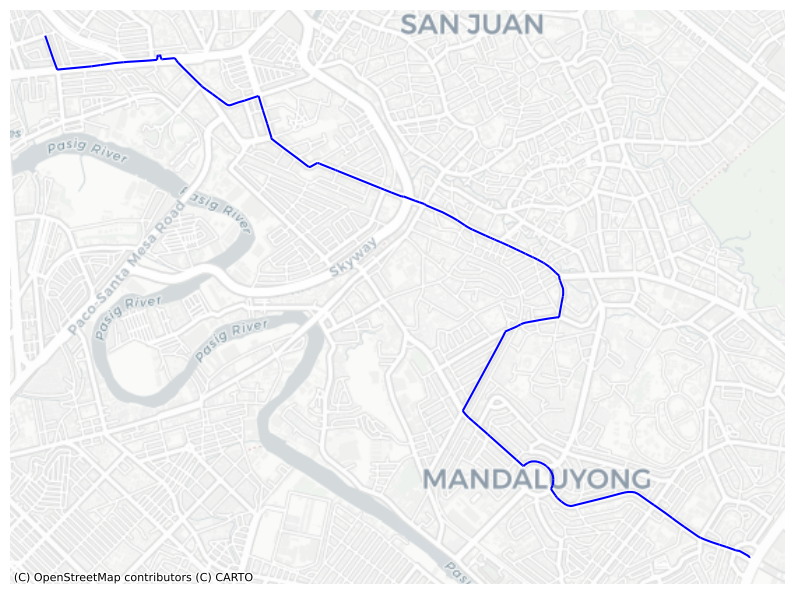

In [154]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_ways_wm = gdf_way_points.to_crs(epsg=3857)
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Plotting nodes.

In [145]:
# Create a GeoDataFrame for ways
gdf_node_points = gpd.GeoSeries(pd.Series(get_nodes()), crs="EPSG:4326")  # WGS84

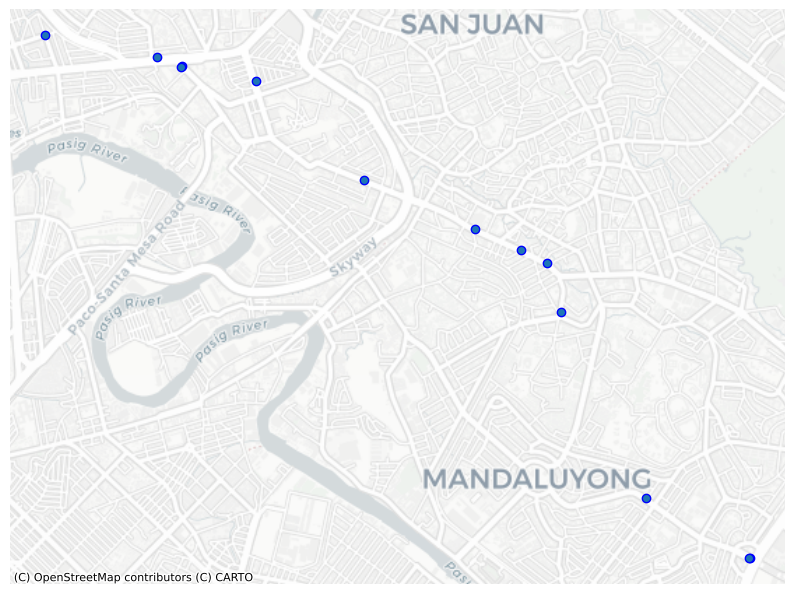

In [146]:
# Plot the result using OSMnx
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm = gdf_node_points.to_crs(epsg=3857)
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Now, let's overlay the nodes and the ways together.

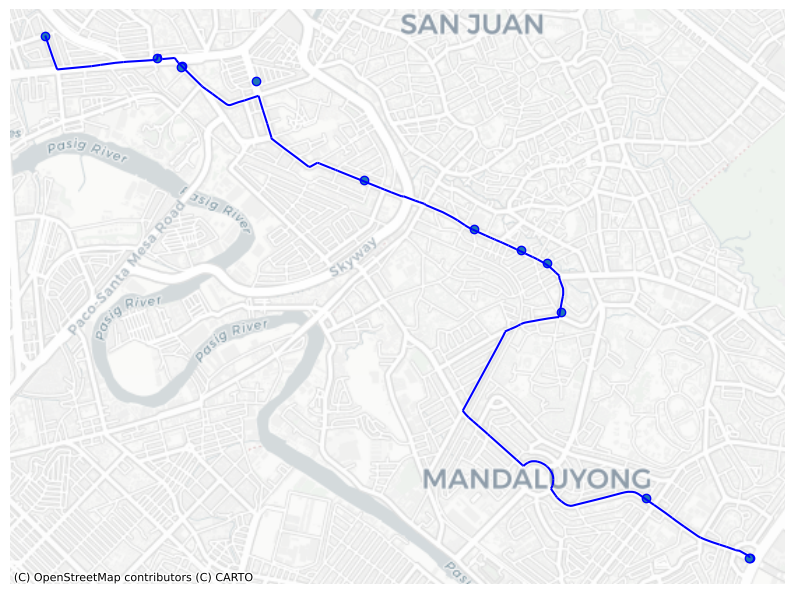

In [147]:
_, ax = plt.subplots(figsize=(10, 10))
gdf_nodes_wm.plot(ax=ax, edgecolor='blue')
gdf_ways_wm.plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

# Conclusion